# Project: Mobile Games A/B Testing (Cookie Cats)

## 1. Introduction
**Cookie Cats** is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter **gates** that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

## 2. The Experiment
But where should the gates be placed? Initially the first gate was placed at **level 30**. In this project, we will analyze an AB-test where the first gate in Cookie Cats was moved from **level 30 to level 40**.

**The Goal:** The objective of this analysis is to determine if there is a statistically significant difference in player retention (Day 1 and Day 7) between the two groups.

## 3. Data Description
The data is from 90,189 players installed the game while the AB-test was running. The variables are:
* `userid`: A unique number that identifies each player.
* `version`: Whether the player was put in the control group (**gate_30** - a gate at level 30) or the group with the moved gate (**gate_40** - a gate at level 40).
* `sum_gamerounds`: The number of game rounds played by the player during the first 14 days after install.
* `retention_1`: Did the player come back and play **1 day** after installing?
* `retention_7`: Did the player come back and play **7 days** after installing?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Cookies Cat/cookie_cats.csv',dtype={"userid":"int32","sum_gamerounds":"int32","version":"str"})

In [3]:
# Cleaning the data by removing the Outlier
p99 = np.percentile(df["sum_gamerounds"],99)
df = df[df['sum_gamerounds'] < 3000]

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df["version"].unique()

array(['gate_30', 'gate_40'], dtype=object)

In [6]:
# Separating the data into two groups
group_a = df[df["version"] == 'gate_30']
group_b = df[df["version"] == 'gate_40']

In [7]:
# Conversion Rate
cr_a = group_a["retention_1"].mean()
cr_b = group_b["retention_1"].mean()
print(f"Conversion Rate for Group A: {cr_a:.2%}")
print(f"Conversion Rate for Group B: {cr_b:.2%}")

# Lift
lift = ((cr_b - cr_a) / cr_a) * 100
print(f"Lift: {lift:.2%}")

Conversion Rate for Group A: 44.82%
Conversion Rate for Group B: 44.23%
Lift: -131.98%


In [8]:
# Z-test
counts = [group_a["retention_1"].sum(),group_b["retention_1"].sum()]
nobs = [len(group_a),len(group_b)]
stat, p_value = sm.stats.proportions_ztest(counts, nobs, alternative='larger')
print(f"Z-Score: {stat:.4f}")
print(f"P-Value: {p_value:.4f}")

Z-Score: 1.7871
P-Value: 0.0370


In [9]:
# Confidence Interval
successes = [group_b["retention_1"].sum(), group_a["retention_1"].sum()]
lower_con, upper_con = confint_proportions_2indep(
    successes[0], nobs[0],
    successes[1], nobs[1],
    method='wald',
    compare='diff')
print(f"95% CI for difference: [{lower_con:.4f}, {upper_con:.4f}]")

95% CI for difference: [0.0032, 0.0162]


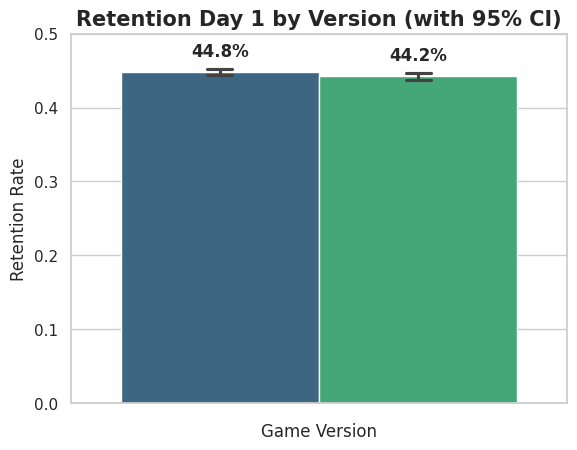

In [10]:
# Visualization
sns.set_theme(style="whitegrid")
ax = sns.barplot(hue='version',y='retention_1',data=df,errorbar=('ci', 95),capsize=.1,palette="viridis", legend=False)
plt.title('Retention Day 1 by Version (with 95% CI)', fontsize=15, fontweight="bold")
plt.xlabel('Game Version', fontsize=12)
plt.ylabel('Retention Rate', fontsize=12)
plt.ylim(0, 0.5)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 15),
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

plt.show()

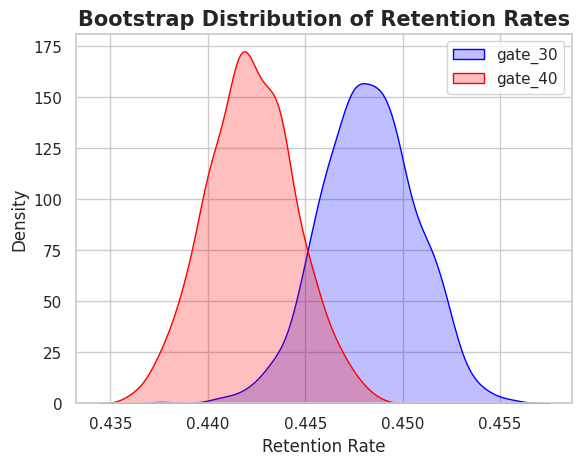

In [11]:
# Bootstrap
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)

# Visualization
sns.kdeplot(boot_1d['gate_30'], fill=True, label='gate_30', color='blue')
sns.kdeplot(boot_1d['gate_40'], fill=True, label='gate_40', color='red')
plt.title('Bootstrap Distribution of Retention Rates', fontsize=15, fontweight="bold")
plt.xlabel('Retention Rate', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

In [12]:
# User Funnel
milestones = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
funnel_data = []

for version in ['gate_30', 'gate_40']:
    group_total = len(df[df['version'] == version])

    for m in milestones:
        survivors = len(df[(df['version'] == version) & (df['sum_gamerounds'] >= m)])
        retention_pct = (survivors / group_total) * 100
        funnel_data.append({
            'Version': version,
            'Rounds_Reached': m,
            'User_Count': survivors,
            'Retention_Percentage': retention_pct
        })
funnel_df = pd.DataFrame(funnel_data)
funnel_df.head(10)

,Version,Rounds_Reached,User_Count,Retention_Percentage
0,gate_30,0,44699,100.000000
1,gate_30,5,34085,76.254502
2,gate_30,10,27864,62.336965
3,gate_30,20,20735,46.388062
4,gate_30,30,16655,37.260341
5,gate_30,40,13565,30.347435
6,gate_30,50,11328,25.342849
7,gate_30,60,9761,21.837178
8,gate_30,70,8567,19.165977
9,gate_30,80,7623,17.054073


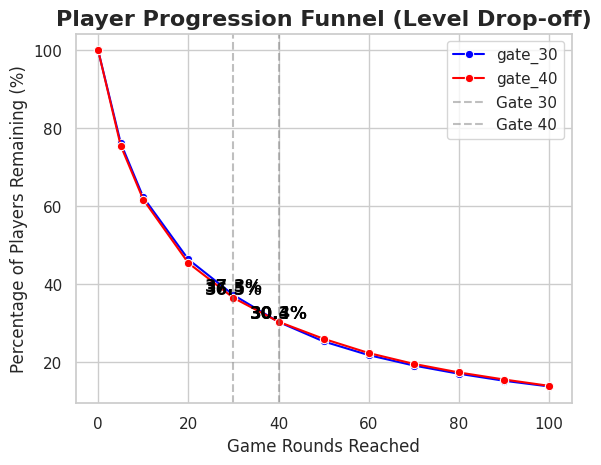

In [13]:
# Visualization
sns.lineplot(data=funnel_df, x='Rounds_Reached', y='Retention_Percentage', hue='Version', marker='o', palette=['blue', 'red'])
plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5, label='Gate 30')
plt.axvline(x=40, color='gray', linestyle='--', alpha=0.5, label='Gate 40')
plt.title('Player Progression Funnel (Level Drop-off)', fontsize=16, fontweight="bold")
plt.xlabel('Game Rounds Reached', fontsize=12)
plt.ylabel('Percentage of Players Remaining (%)', fontsize=12)
plt.legend()
for index, row in funnel_df.iterrows():
    if row['Rounds_Reached'] in [30, 40]:
        plt.text(row['Rounds_Reached'], row['Retention_Percentage'] + 1,
                 f"{row['Retention_Percentage']:.1f}%",
                 ha='center', color='black', fontweight='bold')
plt.show()

In [14]:
# Drop-off Analysis
def calculate_retention_between(start_round, end_round, version):
    subset = df[df['version'] == version]
    start_count = len(subset[subset['sum_gamerounds'] >= start_round])
    end_count = len(subset[subset['sum_gamerounds'] >= end_round])

    if start_count == 0: return 0
    return (end_count / start_count) * 100
retention_30_to_40_A = calculate_retention_between(30, 40, 'gate_30')
retention_30_to_40_B = calculate_retention_between(30, 40, 'gate_40')

print(f"Gate 30 (Group A): {retention_30_to_40_A:.2f}% of users passed level 30 continued to 40.")
print(f"Gate 40 (Group B): {retention_30_to_40_B:.2f}% of users passed level 30 continued to 40.")

diff = retention_30_to_40_B - retention_30_to_40_A
print(f"Difference: {diff:.2f}%")

Gate 30 (Group A): 81.45% of users passed level 30 continued to 40.
Gate 40 (Group B): 83.23% of users passed level 30 continued to 40.
Difference: 1.78%


# Retention for day 7

In [15]:
# Conversion Rate
cr_a7 = group_a["retention_7"].mean()
cr_b7 = group_b["retention_7"].mean()
print(f"Conversion Rate for Group A: {cr_a:.2%}")
print(f"Conversion Rate for Group B: {cr_b:.2%}")

# Lift
lift = ((cr_b7 - cr_a7) / cr_a7) * 100
print(f"Lift: {lift:.1f}%")

Conversion Rate for Group A: 44.82%
Conversion Rate for Group B: 44.23%
Lift: -4.3%


In [16]:
# Z-test
counts7 = [group_a["retention_7"].sum(),group_b["retention_7"].sum()]
nobs7 = [len(group_a),len(group_b)]
stat7, p_value7 = sm.stats.proportions_ztest(counts7, nobs7, alternative='larger')
print(f"Z-Score: {stat7:.4f}")
print(f"P-Value: {p_value7:.4f}")

Z-Score: 3.1574
P-Value: 0.0008


In [17]:
# Confidence Interval
successes7 = [group_a["retention_7"].sum(), group_b["retention_7"].sum()]
nobs7 = [len(group_a), len(group_b)] # تأكد أن nobs7 معرفة هكذا
lower_con7, upper_con7 = confint_proportions_2indep(
    successes7[0], nobs7[0],
    successes7[1], nobs7[1],
    method='wald',
    compare='diff')
print(f"95% CI for difference: [{lower_con7:.4f}, {upper_con7:.4f}]")

95% CI for difference: [0.0031, 0.0133]


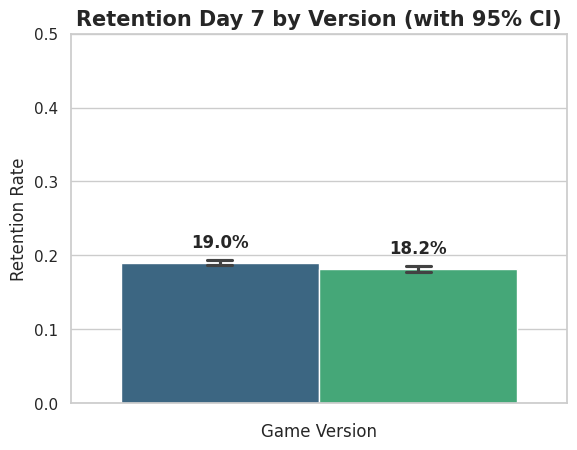

In [18]:
# Visualization
ax7 = sns.barplot(hue='version',y='retention_7',data=df,errorbar=('ci', 95),capsize=.1,palette="viridis", legend=False)
plt.title('Retention Day 7 by Version (with 95% CI)', fontsize=15, fontweight="bold")
plt.xlabel('Game Version', fontsize=12)
plt.ylabel('Retention Rate', fontsize=12)
plt.ylim(0, 0.5)
for p in ax7.patches:
    ax7.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 15),
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

plt.show()

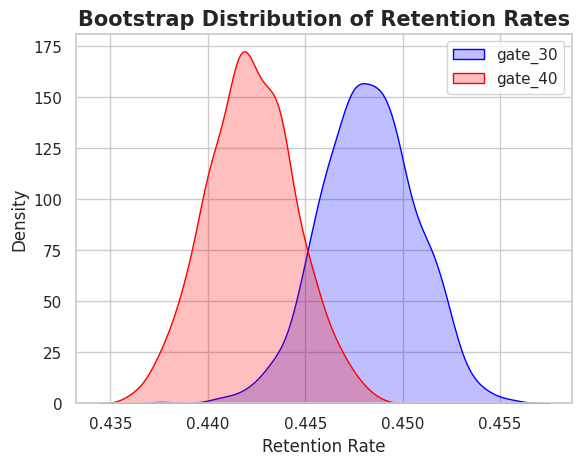

In [19]:
# Bootstrap
boot_1d7 = []
for i in range(1000):
    boot_mean7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d7.append(boot_mean7)

boot_1d7 = pd.DataFrame(boot_1d)

# Visualization
sns.kdeplot(boot_1d7['gate_30'], fill=True, label='gate_30', color='blue')
sns.kdeplot(boot_1d7['gate_40'], fill=True, label='gate_40', color='red')
plt.title('Bootstrap Distribution of Retention Rates', fontsize=15, fontweight="bold")
plt.xlabel('Retention Rate', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

# 4. Conclusion & Business Recommendation

After performing data cleaning, exploratory analysis, bootstrap analysis, and statistical testing (Z-test), we have reached the following conclusions regarding moving the gate from level 30 to level 40:

### Key Findings:
1.  **Day 1 Retention:** There was a slight decrease in 1-day retention when moving the gate to level 40 (44.2%) compared to level 30 (44.8%). The Z-test showed a p-value of **0.037**, indicating this difference is statistically significant.
2.  **Day 7 Retention:** The difference became much more apparent in the long run. 7-day retention dropped from **19.0%** (Gate 30) to **18.2%** (Gate 40). The Z-test p-value was **0.0008**, providing strong evidence that the change negatively impacts long-term player engagement.
3.  **Player Behavior:** The funnel analysis suggests that while players in the `gate_40` group might play slightly more initially (as they don't hit the gate as early), they are less likely to return to the game after a week compared to the `gate_30` group. The "forced break" at level 30 seems to be more effective for player psychology than at level 40.

### Recommendation:
**Do not move the gate to level 40.**

The analysis proves that keeping the gate at **Level 30** results in higher retention rates for both Day 1 and Day 7. Moving the gate to level 40 negatively impacts player loyalty and potentially long-term revenue. Therefore, we recommend keeping the current gate structure at level 30.